# Goal: To extract no snow areas from snow depth rasters based on snow free polygons, calculate IQR, median, mean stats for the areas broken down by land cover
1. Mask the snow depth data and mask the land cover grid by the snow free polygons
2. Classify the landcover grid to its values - ie. road, lake, forest
3. Generate stats for the IQR,median, and mean values
4. Graph the results

In [175]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import pandas as pd
import fiona
import os
from scipy import sparse
%matplotlib inline

In [176]:
#identify watershed
wshed = "VAN"
phase = "P01"
name = wshed + "_" + phase
#raster cell resolution
resolution = 3
#shapefile is the basin used to mask the rasters, should include the total lidar area if not a sub basin
no_snow_mask = r"H:\Metro-Van\2021\GIS\snow_free_shapefiles\VAN_SF.shp"

# path to snowdepth raster, and path to a landcover grid
snow_depth = r"H:\Metro-Van\2021\GIS\snow_depth_rasters\1m_revisedbe_jan27_nocoreg\\" + name + "_sd.tif"
land_cover = r"H:\Metro-Van\2021\GIS\land_cover\\" + wshed + "_lc_clip.tif"


In [177]:
#extract the cooridnates of the no snow mask, note there is a problem here with z values being imported, need to ensure
#z value disabled when exporting from arc (under environments), need to find fix for this!

def coords (no_snow_mask):
    with fiona.open(no_snow_mask) as shapefile:
        for feature in shapefile:
            shapes = [feature["geometry"]]
    return shapes

In [178]:
#call function - output should be paired coordinates, if you have a z value go back a step a re-export shapefile with no z value
mask_coords = coords(no_snow_mask)
display(mask_coords)
type(mask_coords)

[{'type': 'Polygon',
  'coordinates': [[(502758.44937599264, 5476569.740727991),
    (501855.76623742096, 5473777.949417481),
    (501784.2400102755, 5473825.760854486),
    (501781.28558668215, 5473827.762737835),
    (501781.24213962536, 5473827.7920112945),
    (501690.2443702696, 5473888.757900199),
    (501687.28558669053, 5473890.762737831),
    (501687.24213962536, 5473890.792011296),
    (501596.2443700712, 5473951.757900339),
    (501593.2855866896, 5473953.762737831),
    (501593.2421396272, 5473953.792011296),
    (501502.2443702556, 5474014.757900214),
    (501499.2855866868, 5474016.762737833),
    (501499.24278540723, 5474016.791578606),
    (501411.24469174445, 5474075.757682376),
    (501408.28558669705, 5474077.762737831),
    (501408.2441468155, 5474077.790666187),
    (501331.71314323787, 5474129.091034034),
    (501354.1749088848, 5474197.33841053),
    (501354.1872997964, 5474197.37631315),
    (501355.1591989761, 5474200.369452847),
    (501396.1700143004, 5474324

list

In [179]:
#function to open masked array
def open_masked_raster_array(tif):
    with rio.open(tif) as src:
        raster_image, raster_transform = rio.mask.mask(src, mask_coords, crop=True)
        raster_image = raster_image.squeeze()
        return raster_image

In [180]:
snow_depth = open_masked_raster_array(snow_depth)
land_cover = open_masked_raster_array(land_cover)

array([[-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       ...,
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38]], dtype=float32)

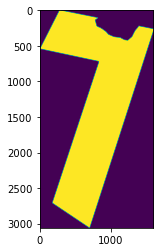

In [181]:
display(snow_depth)
plt.imshow(snow_depth)

array([[-128, -128, -128, ..., -128, -128, -128],
       [-128, -128, -128, ..., -128, -128, -128],
       [-128, -128, -128, ..., -128, -128, -128],
       ...,
       [-128, -128, -128, ..., -128, -128, -128],
       [-128, -128, -128, ..., -128, -128, -128],
       [-128, -128, -128, ..., -128, -128, -128]], dtype=int8)

(3059, 1600)

(3059, 1600)

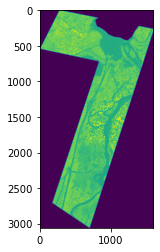

In [182]:
display(land_cover)
plt.imshow(land_cover)
display(land_cover.shape)
#display(mask_coords.shape)
display(snow_depth.shape)

In [183]:
land_cover = land_cover.astype(np.float64)
snow_depth[(land_cover == -128.0)|(snow_depth == np.nan)]=np.nan
land_cover[(land_cover == -128.0)|(snow_depth == np.nan)]=np.nan


In [184]:
display(land_cover)
display(snow_depth)

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [185]:
#unravel
land_cover = np.ravel(land_cover)
snow_depth = np.ravel(snow_depth)

In [186]:
#Convert the unravelled arrays into a data frame form
df = pd.DataFrame({"LC": land_cover, "SD": snow_depth})
display(df)
df = df.dropna()
display(df)

,LC,SD
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
4894395,NaN,NaN
4894396,NaN,NaN
4894397,NaN,NaN
4894398,NaN,NaN


,LC,SD
275,30.0,0.738098
1874,30.0,0.780273
1875,30.0,0.701111
1876,30.0,0.640564
1877,30.0,0.680969
...,...,...
4888697,20.0,-0.267853
4890294,20.0,0.121307
4890295,20.0,-0.009262
4890296,20.0,-0.113586


In [193]:
median = df.groupby(by="LC")["SD"].median()
display(median)
iqr    = df.groupby(by='LC')['SD'].quantile(0.75) - df.groupby(by='LC')['SD'].quantile(0.25)
display(iqr)
mean = df.groupby(by="LC")["SD"].mean()
display(mean)
mean.to_csv("test_mean.csv")

LC
-2.0     0.344421
-1.0     0.330002
 0.0     0.350006
 5.0     0.310013
 10.0    0.296997
 20.0    0.310013
 30.0    0.353806
 40.0    0.393005
 50.0    0.410004
 80.0    0.304321
Name: SD, dtype: float32

LC
-2.0     0.209991
-1.0     0.080017
 0.0     0.172302
 5.0     0.195892
 10.0    0.198242
 20.0    0.253044
 30.0    0.360470
 40.0    0.423252
 50.0    0.481705
 80.0    0.358330
Name: SD, dtype: float64

LC
-2.0    -2.031794e+35
-1.0    -3.356421e+34
 0.0    -6.539044e+34
 5.0    -1.208103e+35
 10.0   -9.704005e+34
 20.0   -1.077528e+35
 30.0   -1.187505e+35
 40.0   -1.440802e+35
 50.0   -1.560715e+35
 80.0   -8.934422e+34
Name: SD, dtype: float32